In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root
from density_correlations import oil_density
from data import Vn, d15_6, roW
from bvp import OrthogonalCollocation
from kinetics import rHDS, rHDN_NB, rHDN_B, rHDA, ft_reactants, effective_reactions
from solubility import Henry_coefficient2_fun, Henry_coefficient4_fun
from mass_balance_equations import k1S_fun, k2S_fun, k4S_fun, k2L_aL_fun, k4L_aL_fun

In [2]:
T = 380+273.15  #Temperature in K

P = 5.3e6 #Pressure in Pa

API = 22

Mm1 = 441.9 #molecuar weigth of the oil.

rho0 = d15_6*roW #Specific gravity of oil.

rhoL = oil_density(rho0,P,T) #density of oil in g/cm^3

rhob = 0.8163 #bulk density in g/cm^3

dp = 0.254 #equivalent diameter in cm

z = 31.54 #length of the reactor

LHSV = 2 # Liquid Hourly Space Velocity in h-1.

diameter_reactor = 2.54 #diameter of the reactor in cm

Ac = np.pi*diameter_reactor**2/4

V_reactor = Ac*z  #Volume of the reactor

fi = 356 #H2/ Oil Ratio std m3/m3

uL = LHSV/3600*V_reactor/Ac #superficial liquid velocity in cm/s.

GL = uL*rhoL #superficial gas velocity in cm/s

uG = uL*(1e5/P)*(T/273.15)*fi #superficial gas velocity in cm/s

def get_bed_fraction(DR, dp):

    return 0.38 + 0.073*(1 + (DR/dp - 2)**2/(DR/dp)**2)


porosity = get_bed_fraction(2.54, 0.254) #value calculate using values of first article

def aS_fun(dp,porosity):

    '''Gets the specific surface area of the packing.

        Parameters
        ----------
        dp: int or float
            equivalent diameter in cm.

        porosity: int or float
                  The void fraction of the catalystic bed.

        Return
        ------
        a_super: float
                 The specific surface area of the packing in cm^-1.
    '''

    return 6*(1-porosity)/dp

aS = aS_fun(dp,porosity)

In [3]:
H2 = Henry_coefficient2_fun(rho0, P,T)

H4 = Henry_coefficient4_fun(rho0, P,T)

k1S_aS = k1S_fun(rho0, P, T, API, GL, aS)*aS

k2S_aS = k2S_fun(rho0, P, T, API, GL, aS)*aS

k4S_aS = k4S_fun(rho0, P, T, API, GL, aS)*aS

k2L_aL = k2L_aL_fun(rho0, P, T, API, GL)

k4L_aL = k4L_aL_fun(rho0, P, T, API, GL)

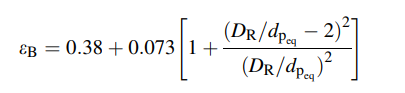

In [4]:
n_points = 6
ivp_rtol=1e-24

In [5]:
w0 = 0.02009 #weigth fraction of sulfur.
w1 = (1284 - 518)*1e-6 #weigth fraction of non basic nitrogen.
w2 = 518*1e-6 #weigth fraction of basic nitrogen.
w3= 0.419 #weigth fraction of aromatic compounds.

## INITIAL CONDITIONS

In [6]:
cL00 = rhoL*w0/Mm1
cL10 = rhoL*w1/Mm1
cL20 = rhoL*w2/Mm1
cL30 = rhoL*w3/Mm1
pG40 = 5.3
pG50 = 0
cL40 = pG40/H2 #inlet concentration of hydrogen in mol/cm^3 .
cL50 = 0 #inlet concentration of hidrogen sulfite in mol/cm^3 .
cL60 = 0 #inlet concentration of naphtneses in mol/cm^3.
z0=0

cl0 = np.array([cL00, cL10, cL20, cL30, cL40, cL50, cL60])


In [7]:
def mass_balance_gas_phase2(p2G, C2L, uG = uG, R=8.3145, T = T):

    return - k2L_aL * (p2G / H2 - C2L) * R * T / uG 

def mass_balance_gas_phase4(p4G, C4L, uG = uG, R=8.3145, T = T):

    return - k4L_aL * (p4G / H4- C4L) * R * T / uG

def mass_balance_gas_liquid_phase2(p2G, C2L, C2S, uL = uL):

    return (k2L_aL * (p2G / H2 - C2L) -  k2S_aS * (C2L - C2S)) / uL

def mass_balance_gas_liquid_phase4(p4G, C4L, C4S, uL = uL):
    
    return (k4L_aL * (p4G / H4 - C4L) -  k4S_aS * (C4L - C4S)) / uL

def mass_balance_liquid(C1L, C1S, uL = uL): 

    return - (C1L - C1S) * k1S_aS / uL

In [8]:
class Concentrations:

    def __init__(self, cl0, heterogeneous):

        self.cs0 = cl0

        self.heterogeneous = heterogeneous

        if heterogeneous:

            self.collocation = OrthogonalCollocation(
                    Concentrations._transport_eq,
                    Concentrations._bc_eq,
                    n_points, 3, x0=0, x1= dp/2)
        

    @staticmethod
    def _transport_eq(r, y, dy, d2y, yb, *args): #partial equations
        return d2y - ft_reactants(r, y, *args)
    
    @staticmethod    
    def _bc_eq(r, y, dy, d2y, yb, *args):  #boundary conditions
        return y - yb

    def mass_balance_surface(self, cs, cl, z):

        eff = np.ones(4)

        if self.heterogeneous:

            if z == 0:

                root_method = 'lm'
                cs[cs == 0] = ivp_rtol
                y0 = np.column_stack((cs,) * (n_points + 1))

            else:
                y0 = self.collocation.y
                root_method = 'hybr'

            args_ft = (cs, cl[7], T)
            self.collocation.collocate(y0, args=args_ft, method=root_method)

            args_reactions = (cl[7], T)
            eff = self.collocation.effectiveness(effective_reactions, args_reactions)

        ni0 = -1
        ni1 = -1
        ni2 = 1
        ni3 = -1
        ni4 = -15
        ni5 = 9
        ni6 = 1    

        F = np.empty((7))
        F[0] =  - ni0*eff[0] * rhob * rHDS(cs,T)  -  k1S_aS*(cl[0] - cs[0])
        F[1] =  - ni1*eff[1] * rhob * rHDN_NB(cs*Mm1/rhoL, T)*rhoL/Mm1  -  k1S_aS * (cl[1] - cs[1])
        F[2] =  - ni2*eff[2] * rhob * rHDN_B(cs*Mm1/rhoL, T)*rhoL/Mm1  -  k1S_aS * (cl[2] - cs[2])
        F[3] =  - ni3*eff[3] * rhob * rHDA(cs, cl[7], T) -  k1S_aS * (cl[3] - cs[3])
        F[4] =  - ni4*eff[0] * rhob * rHDS(cs,T)   - k2S_aS * (cl[4] - cs[4])
        F[5] =  - ni5*eff[0] * rhob * rHDS(cs,T)   - k4S_aS * (cl[5] - cs[5])
        F[6] =  - ni6*eff[3] * rhob * rHDA(cs, cl[7], T) -  k1S_aS * (cl[6] - cs[6])

        return F  
    
    def get_surface_concentrations(self, cl,z):

        self.cs = root(self.mass_balance_surface, self.cs0, (cl,z), method = "hybr").x
        self.cs0 = self.cs   

In [9]:
concentrations = Concentrations(cl0, heterogeneous = False)

In [10]:
def differential_equations(cl, pG4, pG5, cs):

    return np.array([mass_balance_liquid(cl[0], cs[0]),
     mass_balance_liquid(cl[1], cs[1]),
     mass_balance_liquid(cl[2], cs[2]),
     mass_balance_liquid(cl[3], cs[3]),     
     mass_balance_gas_liquid_phase2(pG4, cl[4], cs[4]),
     mass_balance_gas_liquid_phase4(pG5, cl[5], cs[5]),
     mass_balance_liquid(cl[6], cs[6]),
     mass_balance_gas_phase2(pG4, cl[4]),
     mass_balance_gas_phase4(pG5, cl[5])])


In [11]:
def dy(z, variables):

    pG4, pG5 = variables[-2:]

    concentrations.get_surface_concentrations(variables[:-1], z)
    
    solid_concentrations = concentrations.cs

    return differential_equations(variables[:-2], pG4, pG5, solid_concentrations)

In [12]:
t_span = [z0, z]
t_eval = np.linspace(0, z, 100)
y0 = [cL00, cL10, cL20, cL30, cL40, cL50, cL60, pG40, pG50]

In [13]:
sol = solve_ivp(dy, t_span=t_span, y0=y0, t_eval=t_eval, method = "RK45")

In [14]:
cL0_fun,  cL1_fun, cL2_fun, cL3_fun, cL4_fun, cL5_fun, cL6_fun, p4G_fun, p5G_fun = sol.y

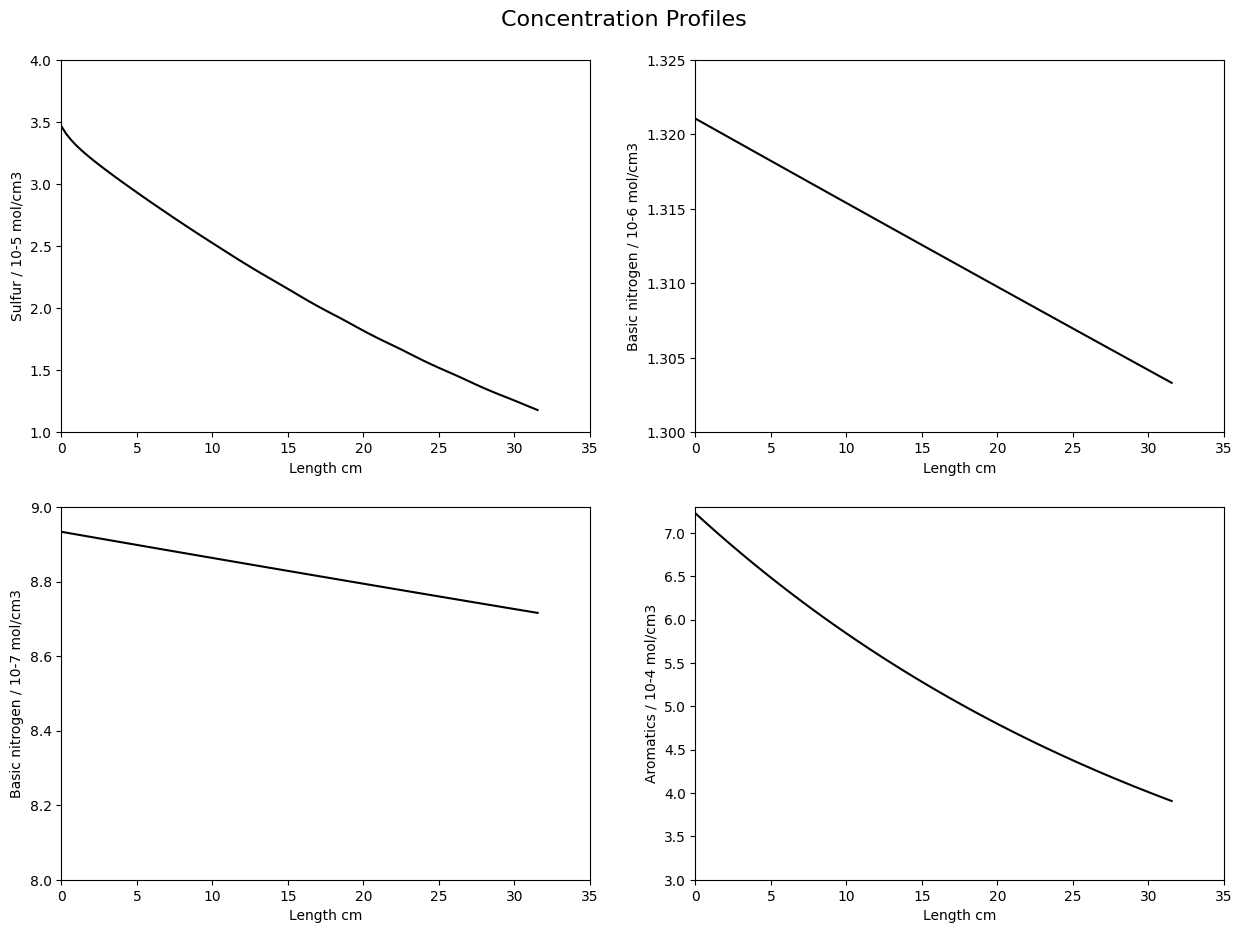

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Plot the first dataset (y_values1) on the left axis (Y-axis)
ax[0,0].plot(t_eval, cL0_fun*1e5, color='black')

ax[0,0].set_xlim(0,35)
ax[0,0].set_ylim(1,4)

# Add labels and a legend
ax[0,0].set_xlabel('Length cm')
ax[0,0].set_ylabel('Sulfur / 10-5 mol/cm3', color='black')

ax[0,1].plot(t_eval, cL1_fun*1e6, color='black')

ax[0,1].set_xlim(0,35)
ax[0,1].set_ylim(1.300,1.325)

# Add labels and a legend
ax[0,1].set_xlabel('Length cm')
ax[0,1].set_ylabel('Basic nitrogen / 10-6 mol/cm3', color='black')

# Add labels and a legend
ax[1,0].set_xlabel('Length cm')
ax[1,0].set_ylabel('Basic nitrogen / 10-7 mol/cm3', color='black')

ax[1,0].plot(t_eval, cL2_fun*1e7, color='black')

ax[1,0].set_xlim(0,35)
ax[1,0].set_ylim(8,9)

# Add labels and a legend
ax[1,0].set_xlabel('Length cm')
ax[1,0].set_ylabel('Basic nitrogen / 10-7 mol/cm3', color='black')

ax[1,1].plot(t_eval, cL3_fun*1e4, color='black')

ax[1,1].set_xlim(0,35)
ax[1,1].set_ylim(3,7.3)

# Add labels and a legend
ax[1,1].set_xlabel('Length cm')
ax[1,1].set_ylabel('Aromatics / 10-4 mol/cm3', color='black')

# Add a title to the entire figure
plt.suptitle("Concentration Profiles", fontsize=16)

# Adjust spacing between the title and the subplots
plt.subplots_adjust(top=0.93)

# Display the graph
plt.show()

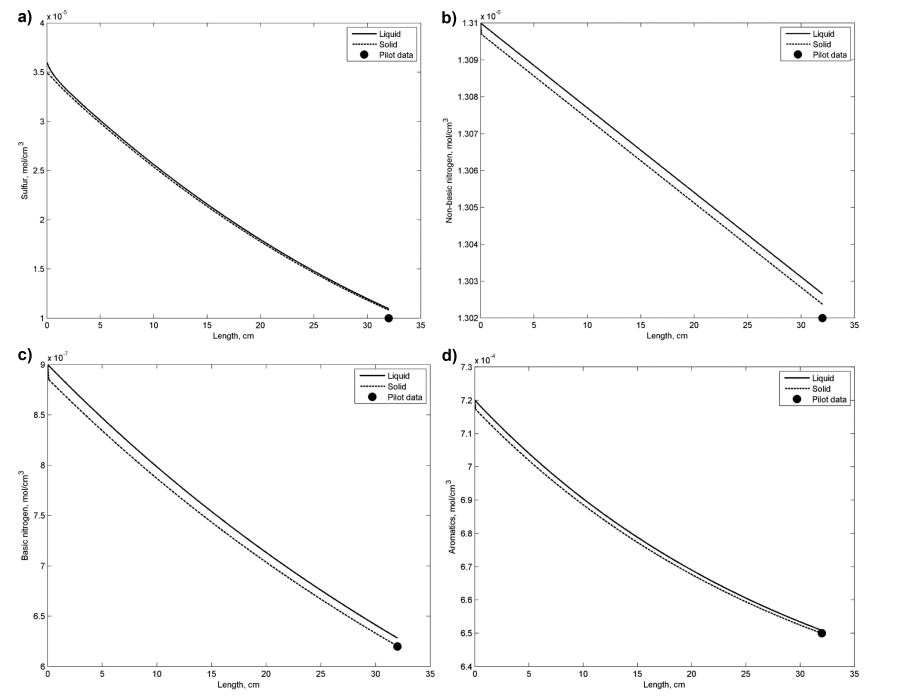

In [16]:
print('Outlet_concentrations')
print(f'Sulfur = {cL0_fun[-1]:.2e} mol/cm3')
print(f'Non basic nitrogen = {cL1_fun[-1]:.2e} mol/cm3')
print(f'Basic nitrogen = {cL2_fun[-1]:.2e} mol/cm3')
print(f'Aromatics = {cL3_fun[-1]:.2e} mol/cm3')

Outlet_concentrations
Sulfur = 1.18e-05 mol/cm3
Non basic nitrogen = 1.30e-06 mol/cm3
Basic nitrogen = 8.72e-07 mol/cm3
Aromatics = 3.91e-04 mol/cm3


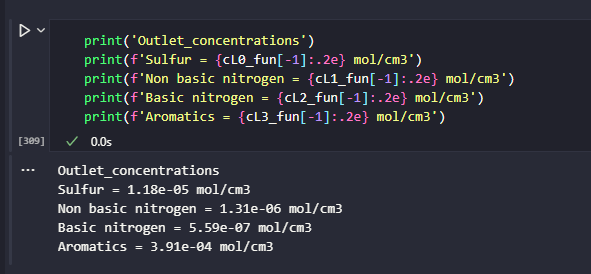